In [14]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, MaxPool2D, Flatten, Activation, BatchNormalization, Add, AveragePooling2D, Input, ZeroPadding2D, concatenate, GlobalAveragePooling2D, Lambda
from keras.initializers import glorot_uniform, Constant
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, RMSprop
from keras.callbacks import LearningRateScheduler
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [15]:
def conv2d(X, num_filters, filter_size, strides=1, padding="same", activation="relu", name=None, kernel_initializer=None, bias_initializer=None):
    X = Conv2D(num_filters, filter_size, strides=strides, padding=padding, 
               kernel_initializer=kernel_initializer, bias_initializer=bias_initializer, name=name)(X)
    X = BatchNormalization(axis=3, scale=False)(X)
    if activation:
        X = Activation(activation)(X)
    return X

In [16]:
def Stem(input_layer, kernel_init, bias_init, name=None):
    X = conv2d(input_layer, 32, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
    X = conv2d(X, 32, (3, 3), strides=1, padding="valid", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)

    X = conv2d(X, 192, (3, 3), strides=1, padding="valid", activation="relu", kernel_initializer=kernel_init,
               bias_initializer=bias_init)
    
#     X1 = MaxPool2D((3, 3), strides=(2, 2), padding="valid")(X)
    
#     X2 = conv2d(X, 96, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init,
#                bias_initializer=bias_init)
    
#     X = concatenate([X1, X2], axis=3)
    
#     X1 = conv2d(X, 64, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
#                bias_initializer=bias_init)

#     X1 = conv2d(X1, 96, (3, 3), strides=1, padding="valid", activation="relu", kernel_initializer=kernel_init,
#                bias_initializer=bias_init)

#     X2 = conv2d(X, 64, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
#                bias_initializer=bias_init)
    
#     X2 = conv2d(X2, 64, (7, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
#                bias_initializer=bias_init)

#     X2 = conv2d(X2, 64, (1, 7), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init,
#                bias_initializer=bias_init)

#     X2 = conv2d(X2, 96, (3, 3), strides=1, padding="valid", activation="relu", kernel_initializer=kernel_init,
#                bias_initializer=bias_init)
    
#     X = concatenate([X1, X2], axis=3)
    
#     X1 = conv2d(X, 192, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init,
#                bias_initializer=bias_init)
    
#     X2 = MaxPool2D((3, 3), strides=(2, 2), padding="valid")(X)
    
#     X = concatenate([X1, X2], axis=3, name=name)
    
    return X

In [17]:
def Normal1(X, X_prev, kernel_init=None, bias_init=None, name=None, scale=1):
    X_short = X
    
    
    X1 = conv2d(X, 64*scale, (1, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X2 = conv2d(X, 32*scale, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X2 = conv2d(X2, 48*scale, (3, 3), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X2 = conv2d(X2, 64*scale, (3, 3), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X_add_1 = Add()([X1, X2])
    X_add_1 = Activation("relu")(X_add_1)
    
    
    X3 = conv2d(X_prev, 64*scale, (1, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X4 = conv2d(X_prev, 32*scale, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X4 = conv2d(X4, 48*scale, (3, 3), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X4 = conv2d(X4, 64*scale, (3, 3), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X_add_2 = Add()([X3, X4])
    X_add_2 = Activation("relu")(X_add_2)
    
    X5 = conv2d(X, 32*scale, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X5 = conv2d(X5, 48*scale, (1, 3), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X5 = conv2d(X5, 64*scale, (3, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X_conc = concatenate([X_add_1, X_add_2, X5], axis=3)
    
    X_conc = conv2d(X_conc, 384*scale, (1, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    X_fin = Add()([X_conc, X_short])
    X_fin = Activation("relu", name=name)(X_fin)
    
    return X_fin

In [18]:
def Normal2(X, X_prev, kernel_init=None, bias_init=None, name=None, scale=1):
    X_short = X
    
    
    X1 = conv2d(X, 64*scale, (1, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X2 = conv2d(X, 32*scale, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X2 = conv2d(X2, 48*scale, (1, 7), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X2 = conv2d(X2, 64*scale, (7, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X_add_1 = Add()([X1, X2])
    X_add_1 = Activation("relu")(X_add_1)
    
    
    X3 = conv2d(X_prev, 64*scale, (1, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X4 = conv2d(X_prev, 32*scale, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X4 = conv2d(X4, 48*scale, (1, 7), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X4 = conv2d(X4, 64*scale, (7, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X_add_2 = Add()([X3, X4])
    X_add_2 = Activation("relu")(X_add_2)
    
    
    X5 = conv2d(X, 32*scale, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X5 = conv2d(X5, 48*scale, (1, 3), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X5 = conv2d(X5, 64*scale, (3, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    X_conc = concatenate([X_add_1, X_add_2, X5], axis=3)
    
    X_conc = conv2d(X_conc, 384*scale, (1, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    X_fin = Add()([X_conc, X_short])
    X_fin = Activation("relu", name=name)(X_fin)
    
    return X_fin

In [19]:
def Normal3(X, X_prev, kernel_init=None, bias_init=None, name=None, scale=1):
    X_short = X
    
    
    X1 = conv2d(X, 64*scale, (1, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X2 = conv2d(X, 32*scale, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X2 = conv2d(X2, 48*scale, (1, 3), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X2 = conv2d(X2, 64*scale, (3, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X_add_1 = Add()([X1, X2])
    X_add_1 = Activation("relu")(X_add_1)
    
    
    X3 = conv2d(X_prev, 64*scale, (1, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X4 = conv2d(X_prev, 32*scale, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X4 = conv2d(X4, 48*scale, (1, 3), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X4 = conv2d(X4, 64*scale, (3, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X_add_2 = Add()([X3, X4])
    X_add_2 = Activation("relu")(X_add_2)
    
    
    X5 = conv2d(X, 32*scale, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X5 = conv2d(X5, 48*scale, (1, 3), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X5 = conv2d(X5, 64*scale, (3, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    
    X_conc = concatenate([X_add_1, X_add_2, X5], axis=3)
    
    X_conc = conv2d(X_conc, 384*scale, (1, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    X_fin = Add()([X_conc, X_short])
    X_fin = Activation("relu", name=name)(X_fin)
    
    return X_fin

In [20]:
def Reduction1(X, X_prev, kernel_init=None, bias_init=None, name=None, scale=1):
    X1 = conv2d(X, 128, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X1 = conv2d(X1, 128, (3, 3), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X2 = conv2d(X_prev, 128, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X2 = conv2d(X2, 128, (1, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    X3 = conv2d(X_prev, 64, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X3 = conv2d(X3, 96, (1, 7), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X3 = conv2d(X3, 128, (7, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X4 = MaxPool2D((3, 3), strides=1, padding="same")(X)
    
    
    X5 = conv2d(X, 96, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X5 = conv2d(X5, 128, (1, 5), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X5 = conv2d(X5, 128, (5, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X6 = MaxPool2D((3, 3), strides=1, padding="same")(X_prev)
    X6 = conv2d(X6, 128, (1, 1), strides=1, padding="same", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    X7 = conv2d(X, 128, (3, 3), strides=2, padding="valid", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    X_add_1 = Add()([X1, X2])
    X_add_1 = Activation("relu")(X_add_1)
    
    
    X8 = MaxPool2D((3, 3), strides=2, padding="valid")(X_add_1)
    
    X_add_1_2 = Add()([X8, X7])
    X_add_1_2 = Activation("relu")(X_add_1_2)
    
    
    X_conc_1 = concatenate([X3, X4], axis=3)
    
    
    X_add_2_1 = Add()([X6, X5])
    X_add_2_1 = Activation("relu")(X_add_2_1)
    
    
    X9 = conv2d(X_conc_1, 128, (3, 3), strides=2, padding="valid", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    X10 = conv2d(X_add_2_1, 128, (3, 3), strides=2, padding="valid", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    X_add_2_2 = Add()([X9, X10])
    X_add_2_2 = Activation("relu")(X_add_2_2)
    
    
    X11 = MaxPool2D((3, 3), strides=2, padding="valid")(X_add_2_1)
    
    
    X_fin = concatenate([X_add_1_2, X_add_2_2, X11], axis=3, name=name)
    X_fin = conv2d(X_fin, 384*scale, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    return X_fin

In [21]:
def Reduction2(X, X_prev, kernel_init=None, bias_init=None, name=None, scale=1):
    X1 = conv2d(X, 48*scale, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X1 = conv2d(X1, 96*scale, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X2 = conv2d(X, 48*scale, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X2 = conv2d(X2, 64*scale, (3, 3), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X2 = conv2d(X2, 96*scale, (3, 3), strides=2, padding="valid", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    X3 = conv2d(X, 64*scale, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X3 = conv2d(X3, 96*scale, (3, 3), strides=2, padding="valid", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    X4 = conv2d(X, 96*scale, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X4 = MaxPool2D((3, 3), strides=2, padding="valid")(X4)
    
    
    X5 = conv2d(X_prev, 48*scale, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X5 = conv2d(X5, 96*scale, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    X6 = conv2d(X_prev, 48*scale, (1, 1), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X6 = conv2d(X6, 64*scale, (3, 3), strides=1, padding="same", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X6 = conv2d(X6, 96*scale, (3, 3), strides=2, padding="valid", activation=None, kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    X_add_1 = Add()([X1, X2])
    X_add_1 = Activation("relu")(X_add_1)
    
    
    X_add_2 = Add()([X5, X6])
    X_add_2 = Activation("relu")(X_add_2)
    
    
    X_fin = concatenate([X_add_1, X_add_2, X3, X4], axis=3, name=name)
    
    return X_fin

In [32]:
def Model1(size=(299, 299, 3), n_classes=5, name=None):
    input_layer = Input(shape=size)
    kernel_init = glorot_uniform()
    bias_init = None
    
    X0 = Stem(input_layer, kernel_init, bias_init, name="Stem")
    X_mem = X0
    X_mem = conv2d(X_mem, 32, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    X_0_1 = conv2d(X0, 192, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init) 
    X_0_2 = MaxPool2D((3, 3), strides=(2, 2), padding="valid")(X0)
    X0 = concatenate([X_0_1, X_0_2], axis=3, name="stem")
    
    
    X1_1 = Normal1(X0, X_mem, name="Norm1_1")
    X1_2 = Normal1(X1_1, X0, name="Norm1_2")
#     X1_3 = Normal3(X1_2, X1_1, name="Norm1_3")
    
    
    X2 = Reduction1(X1_2, X1_1, name="Reduce1", scale=2)
    
    X_mem2 = X1_2
    X_mem2 = conv2d(X_mem2, 32, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    X2_1 = Normal2(X2, X_mem2, name="Norm2_1", scale=2)
    X2_2 = Normal2(X2_1, X2, name="Norm2_2", scale=2)
#     X2_3 = Normal2(X2_2, X2_1, name="Norm2_3", scale=2)


    X3 = Reduction1(X2_2, X2_1, name="Reduce2", scale=3)
    
    X_mem3 = X2_2
    X_mem3 = conv2d(X_mem3, 32, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)
    
    
    X3_1 = Normal2(X3, X_mem3, name="Norm3_1", scale=3)
    X3_2 = Normal2(X3_1, X3, name="Norm3_2", scale=3)
#     X3_3 = Normal3(X3_2, X3_1, name="Norm3_3", scale=3)


    X4 = Reduction1(X3_2, X3_1, name="Reduce3", scale=4)
    
    X_mem4 = X3_2
    X_mem4 = conv2d(X_mem4, 32, (3, 3), strides=2, padding="valid", activation="relu", kernel_initializer=kernel_init, bias_initializer=bias_init)

    
    X4_1 = Normal3(X4, X_mem4, name="Norm4_1", scale=4)
    X4_2 = Normal3(X4_1, X4, name="Norm4_2", scale=4)
    
    
    X_fin = GlobalAveragePooling2D(name="GLBL_Pool")(X4_2)
    X_fin = Dropout(.8)(X_fin)
    X_fin = Dense(n_classes, activation="softmax", name="final_out")(X_fin)
    
    model = Model(input_layer, X_fin, name="V1.0")
    
    return model

In [33]:
nn = Model1()
nn.summary()

Model: "V1.0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_954 (Conv2D)             (None, 149, 149, 32) 896         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_954 (BatchN (None, 149, 149, 32) 96          conv2d_954[0][0]                 
__________________________________________________________________________________________________
activation_756 (Activation)     (None, 149, 149, 32) 0           batch_normalization_954[0][0]    
_______________________________________________________________________________________________

In [33]:
# plot_model(nn, to_file="iter2.png")

In [34]:
import math
nn = Model1(size=(299, 299, 3), n_classes=5)
    
initial_lrate = .02
def decay(epoch, steps=100):
    init_rate = .02
    drop = .95
    epochs_drop = 4
    lrate = init_rate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

RMS = SGD(lr=initial_lrate)
nn.compile(loss=["categorical_crossentropy"], optimizer=RMS, metrics=["accuracy"])

In [35]:
params = [{'samplewise_center':1, 'samplewise_std_normalization':1}, {'featurewise_center':1, 'featurewise_std_normalization':1}, {'rescale':1./255.}]
gen1 = image.ImageDataGenerator(zoom_range=.15, vertical_flip=True, horizontal_flip=True, brightness_range=[.15, 1], rotation_range=30, **params[0])
gen2 = image.ImageDataGenerator(**params[0])
    
train = gen1.flow_from_directory("/home/alex/CourseWork_2020/SelfCutData/SelfCutData/", batch_size=12, target_size=(299, 299), shuffle=1)
test = gen2.flow_from_directory("/home/alex/CourseWork_2020/SelfCutData/Test/", batch_size=2, target_size=(299, 299), shuffle=1)    

Found 975 images belonging to 5 classes.
Found 235 images belonging to 5 classes.


In [36]:
scheduler = LearningRateScheduler(decay, verbose=True)#adde x5 to normal back to old reduct
hist = nn.fit_generator(train, validation_data=test, epochs=200, verbose=1, callbacks=[scheduler])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 82 steps, validate for 118 steps

Epoch 00001: LearningRateScheduler setting learning rate to 0.02.
Epoch 1/200
82/82 [==============================] - 86s 1s/step - loss: 3.1675 - accuracy: 0.3436 - val_loss: 26.8052 - val_accuracy: 0.2128

Epoch 00002: LearningRateScheduler setting learning rate to 0.02.
Epoch 2/200
82/82 [==============================] - 70s 855ms/step - loss: 2.2749 - accuracy: 0.4872 - val_loss: 6.3667 - val_accuracy: 0.2851

Epoch 00003: LearningRateScheduler setting learning rate to 0.02.
Epoch 3/200
82/82 [==============================] - 69s 847ms/step - loss: 1.9948 - accuracy: 0.5508 - val_loss: 3.6330 - val_accuracy: 0.1404

Epoch 00004: LearningRateScheduler setting learning rate to 0.019.
Epoch 4/200
82/82 [==============================] - 70s 850ms/step - loss: 1.9906 - accuracy: 0.5456 - val_loss: 3.2137 - val_accuracy: 0.4043

Epoch 00005: LearningRateScheduler setting learning rate to 0.0

82/82 [==============================] - 70s 851ms/step - loss: 0.1170 - accuracy: 0.9631 - val_loss: 0.8720 - val_accuracy: 0.7957

Epoch 00038: LearningRateScheduler setting learning rate to 0.012604988194492182.
Epoch 38/200
82/82 [==============================] - 70s 849ms/step - loss: 0.0968 - accuracy: 0.9682 - val_loss: 0.3520 - val_accuracy: 0.9064

Epoch 00039: LearningRateScheduler setting learning rate to 0.012604988194492182.
Epoch 39/200
82/82 [==============================] - 69s 847ms/step - loss: 0.1742 - accuracy: 0.9528 - val_loss: 1.3643 - val_accuracy: 0.7574

Epoch 00040: LearningRateScheduler setting learning rate to 0.011974738784767574.
Epoch 40/200
82/82 [==============================] - 70s 848ms/step - loss: 0.1503 - accuracy: 0.9508 - val_loss: 0.7561 - val_accuracy: 0.8213

Epoch 00041: LearningRateScheduler setting learning rate to 0.011974738784767574.
Epoch 41/200
82/82 [==============================] - 69s 847ms/step - loss: 0.1095 - accuracy: 0.970

82/82 [==============================] - 70s 856ms/step - loss: 0.0100 - accuracy: 0.9959 - val_loss: 0.5490 - val_accuracy: 0.9021

Epoch 00074: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 74/200
82/82 [==============================] - 70s 850ms/step - loss: 0.0049 - accuracy: 0.9990 - val_loss: 0.5508 - val_accuracy: 0.8894

Epoch 00075: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 75/200
82/82 [==============================] - 70s 851ms/step - loss: 0.0110 - accuracy: 0.9959 - val_loss: 0.3390 - val_accuracy: 0.9404

Epoch 00076: LearningRateScheduler setting learning rate to 0.007547072050706145.
Epoch 76/200
82/82 [==============================] - 70s 852ms/step - loss: 0.0050 - accuracy: 0.9979 - val_loss: 0.4375 - val_accuracy: 0.9106

Epoch 00077: LearningRateScheduler setting learning rate to 0.007547072050706145.
Epoch 77/200
82/82 [==============================] - 70s 851ms/step - loss: 0.0052 - accuracy: 0.997

82/82 [==============================] - 68s 826ms/step - loss: 0.0059 - accuracy: 0.9979 - val_loss: 0.3127 - val_accuracy: 0.9319

Epoch 00110: LearningRateScheduler setting learning rate to 0.005006881794849098.
Epoch 110/200
82/82 [==============================] - 68s 827ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.3005 - val_accuracy: 0.9277

Epoch 00111: LearningRateScheduler setting learning rate to 0.005006881794849098.
Epoch 111/200
82/82 [==============================] - 68s 827ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.3170 - val_accuracy: 0.9277

Epoch 00112: LearningRateScheduler setting learning rate to 0.004756537705106643.
Epoch 112/200
82/82 [==============================] - 68s 827ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.3129 - val_accuracy: 0.9234

Epoch 00113: LearningRateScheduler setting learning rate to 0.004756537705106643.
Epoch 113/200
82/82 [==============================] - 68s 827ms/step - loss: 0.0032 - accuracy: 0

82/82 [==============================] - 69s 843ms/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.4087 - val_accuracy: 0.9191

Epoch 00146: LearningRateScheduler setting learning rate to 0.003155584295764536.
Epoch 146/200
82/82 [==============================] - 69s 845ms/step - loss: 0.0022 - accuracy: 0.9990 - val_loss: 0.4440 - val_accuracy: 0.9191

Epoch 00147: LearningRateScheduler setting learning rate to 0.003155584295764536.
Epoch 147/200
82/82 [==============================] - 69s 846ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.4499 - val_accuracy: 0.9191

Epoch 00148: LearningRateScheduler setting learning rate to 0.002997805080976309.
Epoch 148/200
82/82 [==============================] - 69s 843ms/step - loss: 0.0066 - accuracy: 0.9979 - val_loss: 0.4475 - val_accuracy: 0.9149

Epoch 00149: LearningRateScheduler setting learning rate to 0.002997805080976309.
Epoch 149/200
82/82 [==============================] - 68s 826ms/step - loss: 0.0031 - accuracy: 0


Epoch 00181: LearningRateScheduler setting learning rate to 0.001988805139741845.
Epoch 181/200
82/82 [==============================] - 68s 828ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 0.3693 - val_accuracy: 0.9234

Epoch 00182: LearningRateScheduler setting learning rate to 0.001988805139741845.
Epoch 182/200
82/82 [==============================] - 68s 827ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.3722 - val_accuracy: 0.9277

Epoch 00183: LearningRateScheduler setting learning rate to 0.001988805139741845.
Epoch 183/200
82/82 [==============================] - 68s 830ms/step - loss: 9.8724e-04 - accuracy: 1.0000 - val_loss: 0.3627 - val_accuracy: 0.9277

Epoch 00184: LearningRateScheduler setting learning rate to 0.0018893648827547527.
Epoch 184/200
82/82 [==============================] - 68s 826ms/step - loss: 7.7691e-04 - accuracy: 1.0000 - val_loss: 0.3631 - val_accuracy: 0.9277

Epoch 00185: LearningRateScheduler setting learning rate to 0.001889364882

In [13]:
# scheduler = LearningRateScheduler(decay, verbose=True)#used 1 2 3 block merthod
# hist = nn.fit_generator(train, validation_data=test, epochs=200, verbose=1, callbacks=[scheduler])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 82 steps, validate for 118 steps

Epoch 00001: LearningRateScheduler setting learning rate to 0.02.
Epoch 1/200
82/82 [==============================] - 98s 1s/step - loss: 4.4661 - accuracy: 0.2882 - val_loss: 23.4242 - val_accuracy: 0.2128

Epoch 00002: LearningRateScheduler setting learning rate to 0.02.
Epoch 2/200
82/82 [==============================] - 73s 893ms/step - loss: 2.8910 - accuracy: 0.4133 - val_loss: 1.9333 - val_accuracy: 0.3830

Epoch 00003: LearningRateScheduler setting learning rate to 0.02.
Epoch 3/200
82/82 [==============================] - 72s 880ms/step - loss: 2.9767 - accuracy: 0.4410 - val_loss: 2.2826 - val_accuracy: 0.4043

Epoch 00004: LearningRateScheduler setting learning rate to 0.019.
Epoch 4/200
82/82 [==============================] - 72s 880ms/step - loss: 1.9871 - accuracy: 0.5333 - val_loss: 13.8651 - val_accu

82/82 [==============================] - 72s 879ms/step - loss: 0.3267 - accuracy: 0.9026 - val_loss: 1.3579 - val_accuracy: 0.7021

Epoch 00035: LearningRateScheduler setting learning rate to 0.013268408625781245.
Epoch 35/200
82/82 [==============================] - 72s 878ms/step - loss: 0.4752 - accuracy: 0.8749 - val_loss: 1.2013 - val_accuracy: 0.6681

Epoch 00036: LearningRateScheduler setting learning rate to 0.012604988194492182.
Epoch 36/200
82/82 [==============================] - 72s 878ms/step - loss: 0.5098 - accuracy: 0.8441 - val_loss: 0.6554 - val_accuracy: 0.8340

Epoch 00037: LearningRateScheduler setting learning rate to 0.012604988194492182.
Epoch 37/200
82/82 [==============================] - 72s 878ms/step - loss: 0.4898 - accuracy: 0.8738 - val_loss: 4.0534 - val_accuracy: 0.5489

Epoch 00038: LearningRateScheduler setting learning rate to 0.012604988194492182.
Epoch 38/200
82/82 [==============================] - 71s 869ms/step - loss: 0.3713 - accuracy: 0.900

82/82 [==============================] - 70s 860ms/step - loss: 0.0591 - accuracy: 0.9795 - val_loss: 1.0385 - val_accuracy: 0.8766

Epoch 00071: LearningRateScheduler setting learning rate to 0.008362406704383542.
Epoch 71/200
82/82 [==============================] - 71s 860ms/step - loss: 0.0443 - accuracy: 0.9897 - val_loss: 0.6571 - val_accuracy: 0.9021

Epoch 00072: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 72/200
82/82 [==============================] - 71s 860ms/step - loss: 0.0474 - accuracy: 0.9856 - val_loss: 2.6592 - val_accuracy: 0.8468

Epoch 00073: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 73/200
82/82 [==============================] - 71s 860ms/step - loss: 0.0455 - accuracy: 0.9846 - val_loss: 1.0582 - val_accuracy: 0.8936

Epoch 00074: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 74/200
82/82 [==============================] - 71s 860ms/step - loss: 0.0342 - accuracy: 0.993

82/82 [==============================] - 71s 860ms/step - loss: 0.0185 - accuracy: 0.9949 - val_loss: 1.0279 - val_accuracy: 0.9106

Epoch 00107: LearningRateScheduler setting learning rate to 0.005270401889314841.
Epoch 107/200
82/82 [==============================] - 71s 860ms/step - loss: 0.0077 - accuracy: 0.9990 - val_loss: 1.0265 - val_accuracy: 0.9021

Epoch 00108: LearningRateScheduler setting learning rate to 0.005006881794849098.
Epoch 108/200
82/82 [==============================] - 71s 860ms/step - loss: 0.0066 - accuracy: 0.9979 - val_loss: 1.1379 - val_accuracy: 0.8979

Epoch 00109: LearningRateScheduler setting learning rate to 0.005006881794849098.
Epoch 109/200
82/82 [==============================] - 71s 860ms/step - loss: 0.0083 - accuracy: 0.9979 - val_loss: 0.9504 - val_accuracy: 0.8809

Epoch 00110: LearningRateScheduler setting learning rate to 0.005006881794849098.
Epoch 110/200
82/82 [==============================] - 71s 860ms/step - loss: 0.0063 - accuracy: 0

82/82 [==============================] - 71s 860ms/step - loss: 0.0052 - accuracy: 0.9990 - val_loss: 0.9691 - val_accuracy: 0.8979

Epoch 00143: LearningRateScheduler setting learning rate to 0.0033216676797521434.
Epoch 143/200
82/82 [==============================] - 71s 861ms/step - loss: 0.0050 - accuracy: 0.9990 - val_loss: 0.9276 - val_accuracy: 0.8979

Epoch 00144: LearningRateScheduler setting learning rate to 0.003155584295764536.
Epoch 144/200
82/82 [==============================] - 71s 860ms/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 1.0588 - val_accuracy: 0.9021

Epoch 00145: LearningRateScheduler setting learning rate to 0.003155584295764536.
Epoch 145/200
82/82 [==============================] - 71s 860ms/step - loss: 0.0032 - accuracy: 0.9990 - val_loss: 1.0386 - val_accuracy: 0.8936

Epoch 00146: LearningRateScheduler setting learning rate to 0.003155584295764536.
Epoch 146/200
82/82 [==============================] - 71s 860ms/step - loss: 0.0028 - accuracy: 

82/82 [==============================] - 71s 860ms/step - loss: 0.0033 - accuracy: 0.9990 - val_loss: 1.1550 - val_accuracy: 0.8936

Epoch 00179: LearningRateScheduler setting learning rate to 0.0020934790944651003.
Epoch 179/200
82/82 [==============================] - 71s 860ms/step - loss: 0.0026 - accuracy: 0.9990 - val_loss: 1.2097 - val_accuracy: 0.8936

Epoch 00180: LearningRateScheduler setting learning rate to 0.001988805139741845.
Epoch 180/200
82/82 [==============================] - 71s 860ms/step - loss: 0.0076 - accuracy: 0.9979 - val_loss: 0.9824 - val_accuracy: 0.9106

Epoch 00181: LearningRateScheduler setting learning rate to 0.001988805139741845.
Epoch 181/200
82/82 [==============================] - 71s 860ms/step - loss: 0.0054 - accuracy: 0.9969 - val_loss: 1.3126 - val_accuracy: 0.8809

Epoch 00182: LearningRateScheduler setting learning rate to 0.001988805139741845.
Epoch 182/200
82/82 [==============================] - 71s 860ms/step - loss: 0.0033 - accuracy: 

In [37]:
# scheduler = LearningRateScheduler(decay, verbose=True)#used new reductionn 3 blocks reductio after
# hist = nn.fit_generator(train, validation_data=test, epochs=200, verbose=1, callbacks=[scheduler])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 82 steps, validate for 118 steps

Epoch 00001: LearningRateScheduler setting learning rate to 0.02.
Epoch 1/200
82/82 [==============================] - 86s 1s/step - loss: 3.6714 - accuracy: 0.3241 - val_loss: 43.3278 - val_accuracy: 0.2170

Epoch 00002: LearningRateScheduler setting learning rate to 0.02.
Epoch 2/200
82/82 [==============================] - 74s 897ms/step - loss: 3.1504 - accuracy: 0.3836 - val_loss: 80.6787 - val_accuracy: 0.2383

Epoch 00003: LearningRateScheduler setting learning rate to 0.02.
Epoch 3/200
82/82 [==============================] - 74s 898ms/step - loss: 2.2852 - accuracy: 0.4964 - val_loss: 5.6570 - val_accuracy: 0.1915

Epoch 00004: LearningRateScheduler setting learning rate to 0.019.
Epoch 4/200
82/82 [==============================] - 74s 899ms/step - loss: 2.1950 - accuracy: 0.5713 - val_loss: 7.9614 - val_accuracy: 0.2596

Epoch 00005: LearningRateScheduler setting learning rate to 0.

82/82 [==============================] - 74s 900ms/step - loss: 0.2849 - accuracy: 0.9292 - val_loss: 0.3350 - val_accuracy: 0.8851

Epoch 00038: LearningRateScheduler setting learning rate to 0.012604988194492182.
Epoch 38/200
82/82 [==============================] - 74s 899ms/step - loss: 0.2198 - accuracy: 0.9385 - val_loss: 1.0526 - val_accuracy: 0.8000

Epoch 00039: LearningRateScheduler setting learning rate to 0.012604988194492182.
Epoch 39/200
82/82 [==============================] - 74s 899ms/step - loss: 0.2162 - accuracy: 0.9405 - val_loss: 1.6350 - val_accuracy: 0.7489

Epoch 00040: LearningRateScheduler setting learning rate to 0.011974738784767574.
Epoch 40/200
82/82 [==============================] - 74s 898ms/step - loss: 0.2801 - accuracy: 0.9251 - val_loss: 0.8370 - val_accuracy: 0.8383

Epoch 00041: LearningRateScheduler setting learning rate to 0.011974738784767574.
Epoch 41/200
82/82 [==============================] - 74s 898ms/step - loss: 0.2067 - accuracy: 0.941

82/82 [==============================] - 82s 1s/step - loss: 0.0637 - accuracy: 0.9846 - val_loss: 0.8664 - val_accuracy: 0.9021

Epoch 00074: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 74/200
82/82 [==============================] - 83s 1s/step - loss: 0.0348 - accuracy: 0.9918 - val_loss: 0.2683 - val_accuracy: 0.9362

Epoch 00075: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 75/200
82/82 [==============================] - 81s 994ms/step - loss: 0.0322 - accuracy: 0.9908 - val_loss: 0.2967 - val_accuracy: 0.9447

Epoch 00076: LearningRateScheduler setting learning rate to 0.007547072050706145.
Epoch 76/200
82/82 [==============================] - 82s 998ms/step - loss: 0.0230 - accuracy: 0.9938 - val_loss: 0.7660 - val_accuracy: 0.8936

Epoch 00077: LearningRateScheduler setting learning rate to 0.007547072050706145.
Epoch 77/200
82/82 [==============================] - 78s 953ms/step - loss: 0.0313 - accuracy: 0.9877 - va

KeyboardInterrupt: 

In [32]:
# scheduler = LearningRateScheduler(decay, verbose=True) #used new reductionn 2 blocks reductio after
# hist = nn.fit_generator(train, validation_data=test, epochs=200, verbose=1, callbacks=[scheduler])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 82 steps, validate for 118 steps

Epoch 00001: LearningRateScheduler setting learning rate to 0.02.
Epoch 1/200
82/82 [==============================] - 75s 916ms/step - loss: 3.6552 - accuracy: 0.3395 - val_loss: 61.6800 - val_accuracy: 0.2255

Epoch 00002: LearningRateScheduler setting learning rate to 0.02.
Epoch 2/200
82/82 [==============================] - 62s 751ms/step - loss: 2.5205 - accuracy: 0.4431 - val_loss: 1.5326 - val_accuracy: 0.4681

Epoch 00003: LearningRateScheduler setting learning rate to 0.02.
Epoch 3/200
82/82 [==============================] - 62s 754ms/step - loss: 2.2382 - accuracy: 0.5077 - val_loss: 7.1622 - val_accuracy: 0.2511

Epoch 00004: LearningRateScheduler setting learning rate to 0.019.
Epoch 4/200
82/82 [==============================] - 62s 753ms/step - loss: 1.8169 - accuracy: 0.5877 - val_loss: 51.2254 - val_accuracy: 0.2936

Epoch 00005: LearningRateScheduler setting learning rate to

82/82 [==============================] - 62s 757ms/step - loss: 0.2376 - accuracy: 0.9303 - val_loss: 0.3356 - val_accuracy: 0.8851

Epoch 00038: LearningRateScheduler setting learning rate to 0.012604988194492182.
Epoch 38/200
82/82 [==============================] - 62s 754ms/step - loss: 0.2014 - accuracy: 0.9436 - val_loss: 1.2760 - val_accuracy: 0.7660

Epoch 00039: LearningRateScheduler setting learning rate to 0.012604988194492182.
Epoch 39/200
82/82 [==============================] - 62s 754ms/step - loss: 0.1406 - accuracy: 0.9508 - val_loss: 1.1409 - val_accuracy: 0.8298

Epoch 00040: LearningRateScheduler setting learning rate to 0.011974738784767574.
Epoch 40/200
82/82 [==============================] - 62s 755ms/step - loss: 0.2359 - accuracy: 0.9323 - val_loss: 0.2839 - val_accuracy: 0.9064

Epoch 00041: LearningRateScheduler setting learning rate to 0.011974738784767574.
Epoch 41/200
82/82 [==============================] - 62s 754ms/step - loss: 0.2181 - accuracy: 0.939

82/82 [==============================] - 62s 755ms/step - loss: 0.0509 - accuracy: 0.9815 - val_loss: 0.3338 - val_accuracy: 0.9191

Epoch 00074: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 74/200
82/82 [==============================] - 62s 754ms/step - loss: 0.0526 - accuracy: 0.9815 - val_loss: 0.5370 - val_accuracy: 0.8851

Epoch 00075: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 75/200
82/82 [==============================] - 62s 758ms/step - loss: 0.0405 - accuracy: 0.9836 - val_loss: 0.7037 - val_accuracy: 0.8553

Epoch 00076: LearningRateScheduler setting learning rate to 0.007547072050706145.
Epoch 76/200
82/82 [==============================] - 63s 772ms/step - loss: 0.0284 - accuracy: 0.9908 - val_loss: 0.3384 - val_accuracy: 0.9277

Epoch 00077: LearningRateScheduler setting learning rate to 0.007547072050706145.
Epoch 77/200
82/82 [==============================] - 63s 771ms/step - loss: 0.0196 - accuracy: 0.994

KeyboardInterrupt: 

In [19]:
# scheduler = LearningRateScheduler(decay, verbose=True) # 2blocks + reduction
# hist = nn.fit_generator(train, validation_data=test, epochs=200, verbose=1, callbacks=[scheduler])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 82 steps, validate for 118 steps

Epoch 00001: LearningRateScheduler setting learning rate to 0.02.
Epoch 1/200
82/82 [==============================] - 77s 940ms/step - loss: 2.8781 - accuracy: 0.3282 - val_loss: 47.1587 - val_accuracy: 0.2128

Epoch 00002: LearningRateScheduler setting learning rate to 0.02.
Epoch 2/200
82/82 [==============================] - 67s 811ms/step - loss: 2.2317 - accuracy: 0.4605 - val_loss: 124.3753 - val_accuracy: 0.2170

Epoch 00003: LearningRateScheduler setting learning rate to 0.02.
Epoch 3/200
82/82 [==============================] - 67s 820ms/step - loss: 1.9862 - accuracy: 0.5415 - val_loss: 1.6796 - val_accuracy: 0.3872

Epoch 00004: LearningRateScheduler setting learning rate to 0.019.
Epoch 4/200
82/82 [==============================] - 67s 814ms/step - loss: 1.6732 - accuracy: 0.6031 - val_loss: 1.1907 - val_accuracy: 0.5106

Epoch 00005: LearningRateScheduler setting learning rate t

KeyboardInterrupt: 

In [11]:
# scheduler = LearningRateScheduler(decay, verbose=True)
# hist = nn.fit_generator(train, validation_data=test, epochs=200, verbose=1, callbacks=[scheduler])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 82 steps, validate for 118 steps

Epoch 00001: LearningRateScheduler setting learning rate to 0.02.
Epoch 1/200
82/82 [==============================] - 107s 1s/step - loss: 2.9914 - accuracy: 0.3549 - val_loss: 65.2638 - val_accuracy: 0.2128

Epoch 00002: LearningRateScheduler setting learning rate to 0.02.
Epoch 2/200
82/82 [==============================] - 79s 965ms/step - loss: 1.9086 - accuracy: 0.5292 - val_loss: 1.6099 - val_accuracy: 0.2809

Epoch 00003: LearningRateScheduler setting learning rate to 0.02.
Epoch 3/200
82/82 [==============================] - 80s 980ms/step - loss: 2.0175 - accuracy: 0.5169 - val_loss: 8.8719 - val_accuracy: 0.3489

Epoch 00004: LearningRateScheduler setting learning rate to 0.019.
Epoch 4/200
82/82 [==============================] - 79s 964ms/step - loss: 1.5261 - accuracy: 0.6051 - val_loss: 398.2035 - val_ac

82/82 [==============================] - 79s 961ms/step - loss: 0.0066 - accuracy: 0.9979 - val_loss: 0.4270 - val_accuracy: 0.9106

Epoch 00071: LearningRateScheduler setting learning rate to 0.008362406704383542.
Epoch 71/200
82/82 [==============================] - 79s 960ms/step - loss: 0.0109 - accuracy: 0.9959 - val_loss: 0.5375 - val_accuracy: 0.8851

Epoch 00072: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 72/200
82/82 [==============================] - 78s 954ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.4593 - val_accuracy: 0.8894

Epoch 00073: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 73/200
82/82 [==============================] - 80s 979ms/step - loss: 0.0059 - accuracy: 0.9969 - val_loss: 0.4038 - val_accuracy: 0.9064

Epoch 00074: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 74/200
14/82 [====>.........................] - ETA: 1:00 - loss: 0.0056 - accuracy: 1.0000

KeyboardInterrupt: 

In [21]:
# scheduler = LearningRateScheduler(decay, verbose=True)
# hist = nn.fit_generator(train, validation_data=test, epochs=200, verbose=1, callbacks=[scheduler])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 82 steps, validate for 118 steps

Epoch 00001: LearningRateScheduler setting learning rate to 0.02.
Epoch 1/200
82/82 [==============================] - 77s 939ms/step - loss: 3.4240 - accuracy: 0.3272 - val_loss: 22.7478 - val_accuracy: 0.2128

Epoch 00002: LearningRateScheduler setting learning rate to 0.02.
Epoch 2/200
82/82 [==============================] - 64s 777ms/step - loss: 2.3625 - accuracy: 0.4697 - val_loss: 100.6627 - val_accuracy: 0.2170

Epoch 00003: LearningRateScheduler setting learning rate to 0.02.
Epoch 3/200
82/82 [==============================] - 64s 778ms/step - loss: 2.0708 - accuracy: 0.5231 - val_loss: 2.7186 - val_accuracy: 0.2553

Epoch 00004: LearningRateScheduler setting learning rate to 0.019.
Epoch 4/200
82/82 [==============================] - 64s 777ms/step - loss: 1.6742 - accuracy: 0.6082 - val_loss: 3.4799 - val_accuracy: 0.2043

Epoch 00005: LearningRateScheduler setting learning rate t

82/82 [==============================] - 62s 761ms/step - loss: 0.2290 - accuracy: 0.9251 - val_loss: 0.7003 - val_accuracy: 0.8128

Epoch 00038: LearningRateScheduler setting learning rate to 0.012604988194492182.
Epoch 38/200
82/82 [==============================] - 62s 761ms/step - loss: 0.2205 - accuracy: 0.9344 - val_loss: 0.7753 - val_accuracy: 0.8553

Epoch 00039: LearningRateScheduler setting learning rate to 0.012604988194492182.
Epoch 39/200
82/82 [==============================] - 62s 761ms/step - loss: 0.2168 - accuracy: 0.9374 - val_loss: 0.9106 - val_accuracy: 0.8043

Epoch 00040: LearningRateScheduler setting learning rate to 0.011974738784767574.
Epoch 40/200
82/82 [==============================] - 62s 761ms/step - loss: 0.1979 - accuracy: 0.9518 - val_loss: 0.8215 - val_accuracy: 0.8298

Epoch 00041: LearningRateScheduler setting learning rate to 0.011974738784767574.
Epoch 41/200
82/82 [==============================] - 62s 761ms/step - loss: 0.2341 - accuracy: 0.931

82/82 [==============================] - 62s 761ms/step - loss: 0.0887 - accuracy: 0.9795 - val_loss: 0.6251 - val_accuracy: 0.8766

Epoch 00074: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 74/200
82/82 [==============================] - 62s 761ms/step - loss: 0.0287 - accuracy: 0.9887 - val_loss: 0.5407 - val_accuracy: 0.9021

Epoch 00075: LearningRateScheduler setting learning rate to 0.007944286369164364.
Epoch 75/200
82/82 [==============================] - 62s 761ms/step - loss: 0.0230 - accuracy: 0.9918 - val_loss: 0.5847 - val_accuracy: 0.8894

Epoch 00076: LearningRateScheduler setting learning rate to 0.007547072050706145.
Epoch 76/200
82/82 [==============================] - 62s 761ms/step - loss: 0.0353 - accuracy: 0.9897 - val_loss: 0.6138 - val_accuracy: 0.8851

Epoch 00077: LearningRateScheduler setting learning rate to 0.007547072050706145.
Epoch 77/200
82/82 [==============================] - 62s 761ms/step - loss: 0.0222 - accuracy: 0.996

82/82 [==============================] - 62s 761ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.4546 - val_accuracy: 0.9191

Epoch 00110: LearningRateScheduler setting learning rate to 0.005006881794849098.
Epoch 110/200
82/82 [==============================] - 65s 790ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.4072 - val_accuracy: 0.9149

Epoch 00111: LearningRateScheduler setting learning rate to 0.005006881794849098.
Epoch 111/200
82/82 [==============================] - 65s 795ms/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.4764 - val_accuracy: 0.9149

Epoch 00112: LearningRateScheduler setting learning rate to 0.004756537705106643.
Epoch 112/200
82/82 [==============================] - 64s 778ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.4793 - val_accuracy: 0.9149

Epoch 00113: LearningRateScheduler setting learning rate to 0.004756537705106643.
Epoch 113/200
82/82 [==============================] - 64s 778ms/step - loss: 0.0192 - accuracy: 0

82/82 [==============================] - 64s 786ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.4933 - val_accuracy: 0.9064

Epoch 00146: LearningRateScheduler setting learning rate to 0.003155584295764536.
Epoch 146/200
82/82 [==============================] - 64s 786ms/step - loss: 0.0037 - accuracy: 0.9990 - val_loss: 0.4871 - val_accuracy: 0.9064

Epoch 00147: LearningRateScheduler setting learning rate to 0.003155584295764536.
Epoch 147/200
77/82 [===========================>..] - ETA: 3s - loss: 9.5555e-04 - accuracy: 1.0000


KeyboardInterrupt



/home/alex/anaconda3/envs/tf36/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'lower rigth'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


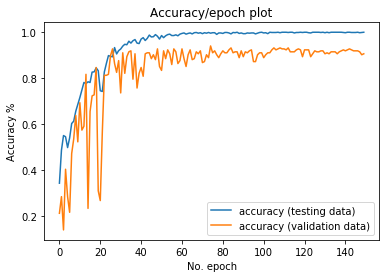

In [47]:
plt.plot(hist.history['accuracy'][:150], label='accuracy (testing data)')
plt.plot(hist.history['val_accuracy'][:150], label='accuracy (validation data)')
plt.title('Accuracy/epoch plot')
plt.ylabel('Accuracy %')
plt.xlabel('No. epoch')
plt.legend(loc="lower rigth")
plt.show()

In [13]:
Test = gen1.flow_from_directory("/home/alex/CourseWork_2020/SelfCutData/TestMod//", target_size=(299, 299), shuffle=False, batch_size=10)

Found 134 images belonging to 5 classes.


In [14]:
nn.evaluate_generator(Test, verbose=1)

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
14/14 [==============================] - 7s 477ms/step - loss: 0.1144 - accuracy: 0.9552


[0.11436130449886608, 0.95522386]

In [41]:
import numpy as np

In [43]:
np.median(hist.history["val_accuracy"])

0.9148936

In [48]:
import pickle

In [49]:
with open("hist_iter2.pickle", "wb") as f:
    pickle.dump(hist.history, f)

In [51]:
nn.save("MODEL_second_iter200ep.h5")